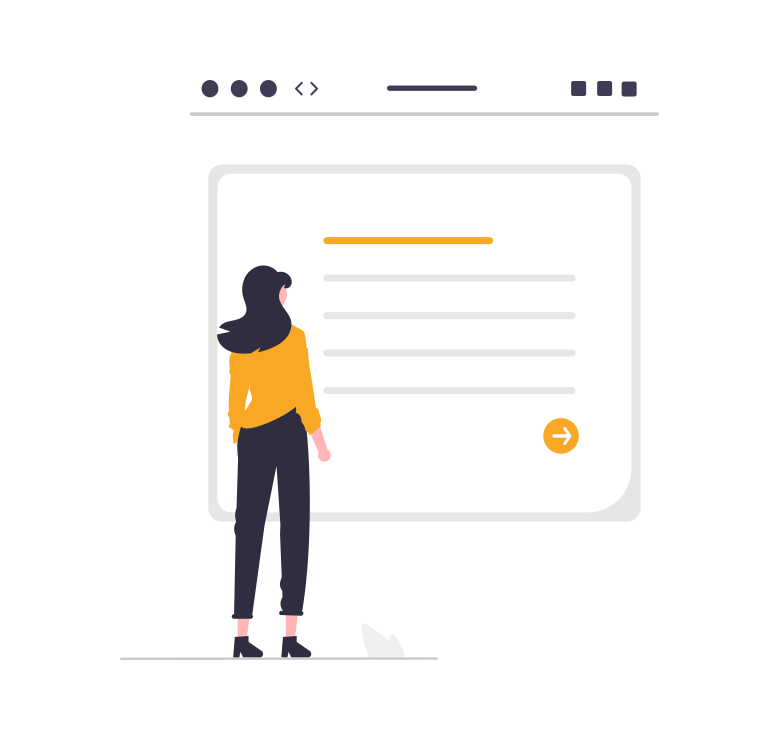

## Main Concept

In my [previous notebook](https://www.kaggle.com/code/tsunotsuno/debertav3-w-prompt-title-question-fields), the `text`, `prompt_title` and `prompt_question` fields, which slightly improved the LB values.
As far as my past CVs are concerned, the value of `wording_rmse` is clearly worse than the value of `content_rmse`. I think improving `content_rmse` leds to improve the overall score as well.
In this notebook, I'll check whether the accuracy of `wording score` can be improved by combining features related to NLP.

제 [이전 노트북](https://www.kaggle.com/code/tsunotsuno/debertav3-w-prompt-title-question-fields)에서는 `text`, `prompt_title`, `prompt_question` 필드를 수정하여 LB 값을 약간 개선했습니다.
과거 이력서를 보면 `wording_rmse`의 값이 `content_rmse`의 값보다 확실히 나쁩니다. 'content_rmse'를 개선하면 전체 점수도 향상될 수 있을 것 같습니다.
이번 노트북에서는 NLP와 관련된 기능들을 조합해서 `wording score`의 정확도를 높일 수 있는지 확인해 보겠습니다.


### Feature Engineering

Features related to the similarity found between `prompt_text` and `text` may be related to the wording_score. Therefore, I'll create following features.

[Using features]

- Text Length
- Length Ratio
- Word Overlap
- N-grams Co-occurrence
- Quotes Overlap
- Grammar Check
  - spelling: pyspellchecker

<!--
  - grammer: [skip]
- Semantic Similarity
  - [skip]
-->

### Model Architecture

그림과 같은 구성의 모델을 만든다.

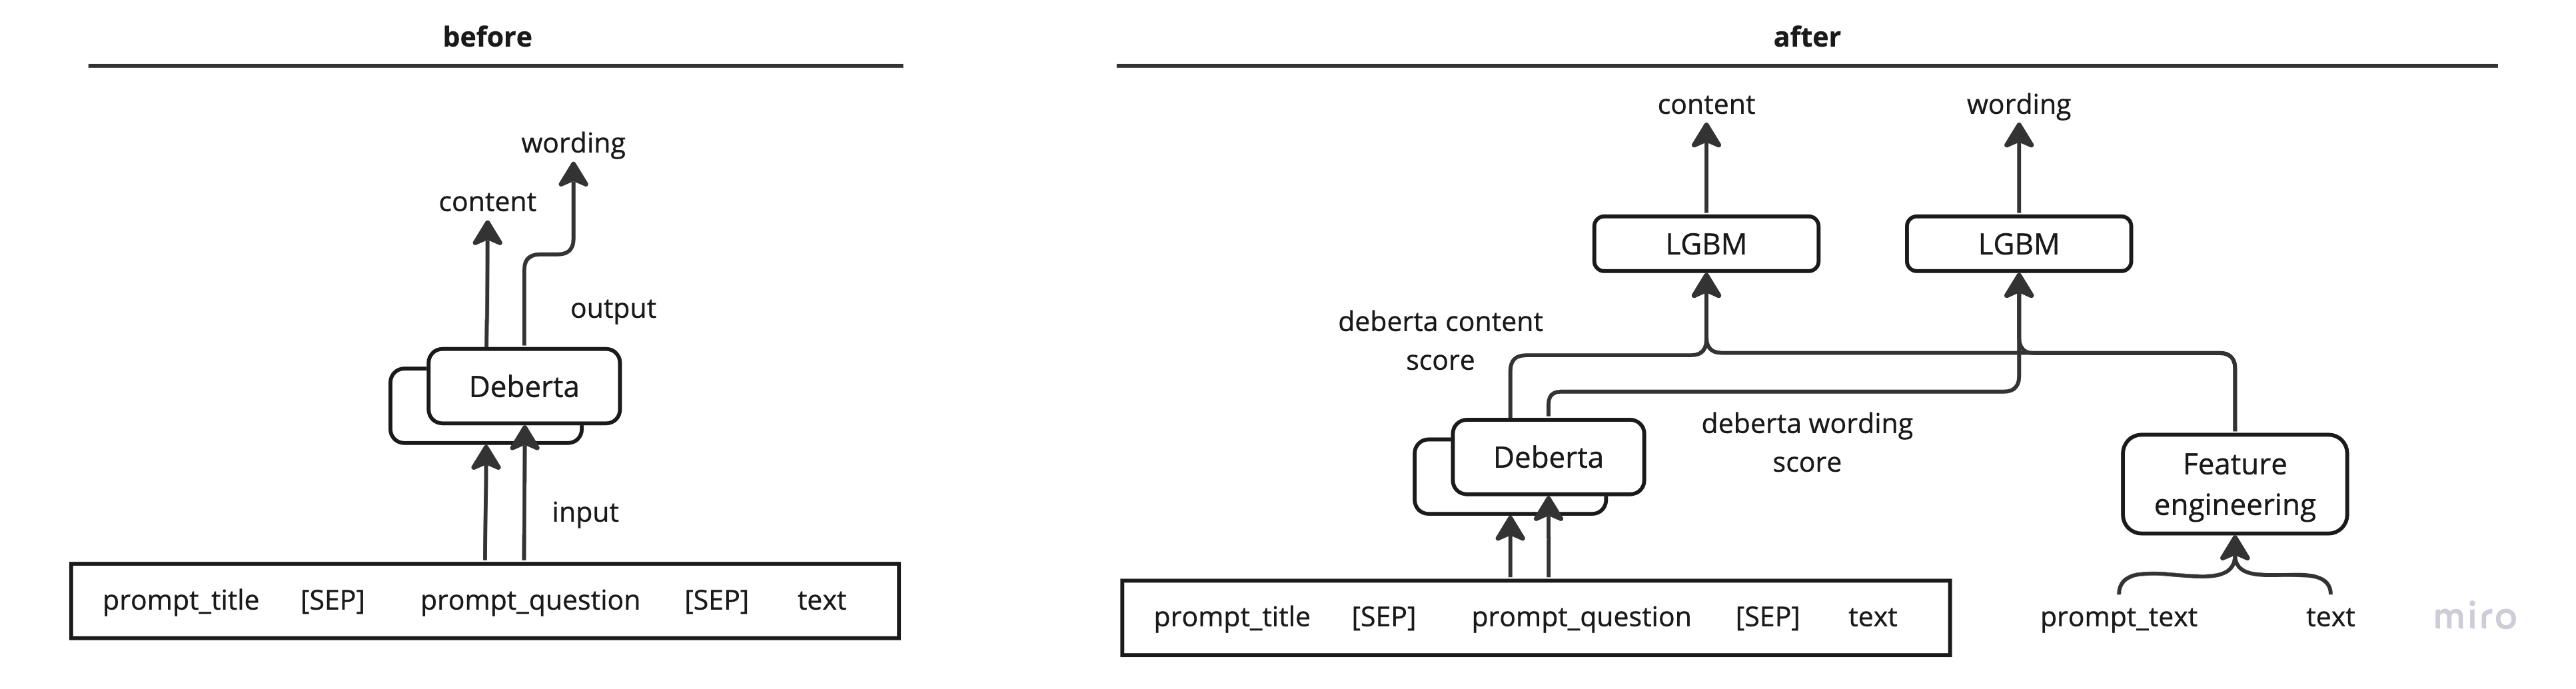

이번에는 wording_rmse를 개선하기 위해 NLP 관련 특징과 LGBM을 결합했다.

### References

- https://www.kaggle.com/code/kieserel/deberta-additional-features
- https://www.kaggle.com/code/vassylkorzh/feature-engineering

### My previous notebooks

- https://www.kaggle.com/code/tsunotsuno/debertav3-baseline-content-and-wording-models
- https://www.kaggle.com/code/tsunotsuno/debertav3-w-prompt-title-question-fields
- https://www.kaggle.com/code/tsunotsuno/debertav3-with-llama2-example


In [1]:
#!pip install "/kaggle/input/autocorrect/autocorrect-2.6.1.tar"
!pip install "/kaggle/input/pyspellchecker/pyspellchecker-0.7.2-py3-none-any.whl"

Processing /kaggle/input/pyspellchecker/pyspellchecker-0.7.2-py3-none-any.whl


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import logging
import os
import shutil
import json
import transformers
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from datasets import Dataset,load_dataset, load_from_disk
from transformers import TrainingArguments, Trainer
from datasets import load_metric, disable_progress_bar
from sklearn.metrics import mean_squared_error
import torch
from sklearn.model_selection import KFold, GroupKFold
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from collections import Counter
import spacy
import re
#from autocorrect import Speller
from spellchecker import SpellChecker
import lightgbm as lgb

# logging setting 

warnings.simplefilter("ignore")
logging.disable(logging.ERROR)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
disable_progress_bar()
tqdm.pandas()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
# set random seed
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
    
seed_everything(seed=42)

In [4]:
class CFG:
    model_name="debertav3base"
    learning_rate=1.5e-5
    weight_decay=0.02
    hidden_dropout_prob=0.005
    attention_probs_dropout_prob=0.005
    num_train_epochs=5
    n_splits=4
    batch_size=12
    random_seed=42
    save_steps=100
    max_length=512


## Dataload

In [5]:
DATA_DIR = "/kaggle/input/commonlit-evaluate-student-summaries/"

prompts_train = pd.read_csv(DATA_DIR + "prompts_train.csv")
prompts_test = pd.read_csv(DATA_DIR + "prompts_test.csv")
summaries_train = pd.read_csv(DATA_DIR + "summaries_train.csv")
summaries_test = pd.read_csv(DATA_DIR + "summaries_test.csv")
sample_submission = pd.read_csv(DATA_DIR + "sample_submission.csv")


#summaries_train = summaries_train.head(10) # for dev mode


## Preprocess


[Using features]

- Text Length
- Length Ratio
- Word Overlap
- N-grams Co-occurrence
- Quotes Overlap
- Grammar Check
  - spelling: pyspellchecker

NOTE: I don't know why, but I can't use nltk.ngrams function. (my submission fails "Submission CSV Not Found") 
So, I write and use original ngram function.

In [6]:
class Preprocessor:
    def __init__(self, 
                model_name: str,
                ) -> None:
        self.tokenizer = AutoTokenizer.from_pretrained(f"/kaggle/input/{model_name}")
        self.STOP_WORDS = set(stopwords.words('english'))
        
        self.spacy_ner_model = spacy.load('en_core_web_sm',)
        self.speller = SpellChecker() #Speller(lang='en')
        
    def count_text_length(self, df: pd.DataFrame, col:str) -> pd.Series:
        """ text length """
        tokenizer=self.tokenizer
        return df[col].progress_apply(lambda x: len(tokenizer.encode(x)))

    def word_overlap_count(self, row):
        """ intersection(prompt_text, text) """        
        def check_is_stop_word(word):
            return word in self.STOP_WORDS
        
        prompt_words = row['prompt_tokens']
        summary_words = row['summary_tokens']
        if self.STOP_WORDS:
            prompt_words = list(filter(check_is_stop_word, prompt_words))
            summary_words = list(filter(check_is_stop_word, summary_words))
        return len(set(prompt_words).intersection(set(summary_words)))
            
    def ngrams(self, token, n):
        # Use the zip function to help us generate n-grams
        # Concatentate the tokens into ngrams and return
        ngrams = zip(*[token[i:] for i in range(n)])
        return [" ".join(ngram) for ngram in ngrams]

    def ngram_co_occurrence(self, row, n: int):
        # Tokenize the original text and summary into words
        original_tokens = row['prompt_tokens']
        summary_tokens = row['summary_tokens']

        # Generate n-grams for the original text and summary
        original_ngrams = set(self.ngrams(original_tokens, n))
        summary_ngrams = set(self.ngrams(summary_tokens, n))

        # Calculate the number of common n-grams
        common_ngrams = original_ngrams.intersection(summary_ngrams)

        # # Optionally, you can get the frequency of common n-grams for a more nuanced analysis
        # original_ngram_freq = Counter(ngrams(original_words, n))
        # summary_ngram_freq = Counter(ngrams(summary_words, n))
        # common_ngram_freq = {ngram: min(original_ngram_freq[ngram], summary_ngram_freq[ngram]) for ngram in common_ngrams}

        return len(common_ngrams)
    
    def ner_overlap_count(self, row, mode:str):
        model = self.spacy_ner_model
        def clean_ners(ner_list):
            return set([(ner[0].lower(), ner[1]) for ner in ner_list])
        prompt = model(row['prompt_text'])
        summary = model(row['text'])

        if "spacy" in str(model):
            prompt_ner = set([(token.text, token.label_) for token in prompt.ents])
            summary_ner = set([(token.text, token.label_) for token in summary.ents])
        elif "stanza" in str(model):
            prompt_ner = set([(token.text, token.type) for token in prompt.ents])
            summary_ner = set([(token.text, token.type) for token in summary.ents])
        else:
            raise Exception("Model not supported")

        prompt_ner = clean_ners(prompt_ner)
        summary_ner = clean_ners(summary_ner)

        intersecting_ners = prompt_ner.intersection(summary_ner)
        
        ner_dict = dict(Counter([ner[1] for ner in intersecting_ners]))
        
        if mode == "train":
            return ner_dict
        elif mode == "test":
            return {key: ner_dict.get(key) for key in self.ner_keys}

    
    def quotes_count(self, row):
        summary = row['text']
        text = row['prompt_text']
        quotes_from_summary = re.findall(r'"([^"]*)"', summary)
        if len(quotes_from_summary)>0:
            return [quote in text for quote in quotes_from_summary].count(True)
        else:
            return 0

    def spelling(self, text):
        
        wordlist=text.split()
        amount_miss = len(list(self.speller.unknown(wordlist)))

        return amount_miss
    
    def run(self, 
            prompts: pd.DataFrame,
            summaries:pd.DataFrame,
            mode:str
        ) -> pd.DataFrame:
        
        # before merge preprocess
        prompts["prompt_length"] = prompts["prompt_text"].apply(
            lambda x: len(self.tokenizer.encode(x))
        )
        prompts["prompt_tokens"] = prompts["prompt_text"].apply(
            lambda x: self.tokenizer.convert_ids_to_tokens(
                self.tokenizer.encode(x), 
                skip_special_tokens=True
            )
        )

        summaries["summary_length"] = summaries["text"].apply(
            lambda x: len(self.tokenizer.encode(x))
        )
        summaries["summary_tokens"] = summaries["text"].apply(
            lambda x: self.tokenizer.convert_ids_to_tokens(
                self.tokenizer.encode(x), 
                skip_special_tokens=True
            )

        )
        summaries["splling_err_num"] = summaries["text"].progress_apply(self.spelling)

        # merge prompts and summaries
        input_df = summaries.merge(prompts, how="left", on="prompt_id")

        # after merge preprocess
        input_df['length_ratio'] = input_df['summary_length'] / input_df['prompt_length']
        
        input_df['word_overlap_count'] = input_df.progress_apply(self.word_overlap_count, axis=1)
        input_df['bigram_overlap_count'] = input_df.progress_apply(
            self.ngram_co_occurrence,args=(2,), axis=1 
        )
        input_df['trigram_overlap_count'] = input_df.progress_apply(
            self.ngram_co_occurrence, args=(3,), axis=1
        )
        
        # Crate dataframe with count of each category NERs overlap for all the summaries
        # Because it spends too much time for this feature, I don't use this time.
#         ners_count_df  = input_df.progress_apply(
#             lambda row: pd.Series(self.ner_overlap_count(row, mode=mode), dtype='float64'), axis=1
#         ).fillna(0)
#         self.ner_keys = ners_count_df.columns
#         ners_count_df['sum'] = ners_count_df.sum(axis=1)
#         ners_count_df.columns = ['NER_' + col for col in ners_count_df.columns]
#         # join ner count dataframe with train dataframe
#         input_df = pd.concat([input_df, ners_count_df], axis=1)
        
        input_df['quotes_count'] = input_df.progress_apply(self.quotes_count, axis=1)
        
        return input_df.drop(columns=["summary_tokens", "prompt_tokens"])
    
preprocessor = Preprocessor(model_name=CFG.model_name)

In [7]:
train = preprocessor.run(prompts_train, summaries_train, mode="train")
test = preprocessor.run(prompts_test, summaries_test, mode="test")

test.head()

100%|██████████| 4/4 [00:00<00:00, 2499.96it/s]


,student_id,prompt_id,text,summary_length,splling_err_num,prompt_question,prompt_title,prompt_text,prompt_length,length_ratio,word_overlap_count,bigram_overlap_count,trigram_overlap_count,quotes_count
0,000000ffffff,abc123,Example text 1,5,0,Summarize...,Example Title 1,Heading\nText...,7,0.714286,0,0,0,0
1,111111eeeeee,def789,Example text 2,5,0,Summarize...,Example Title 2,Heading\nText...,7,0.714286,0,0,0,0
2,222222cccccc,abc123,Example text 3,5,0,Summarize...,Example Title 1,Heading\nText...,7,0.714286,0,0,0,0
3,333333dddddd,def789,Example text 4,5,0,Summarize...,Example Title 2,Heading\nText...,7,0.714286,0,0,0,0


In [8]:
gkf = GroupKFold(n_splits=CFG.n_splits)

for i, (_, val_index) in enumerate(gkf.split(train, groups=train["prompt_id"])):
    train.loc[val_index, "fold"] = i

train.head()

,student_id,prompt_id,text,content,wording,summary_length,splling_err_num,prompt_question,prompt_title,prompt_text,prompt_length,length_ratio,word_overlap_count,bigram_overlap_count,trigram_overlap_count,quotes_count,fold
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,69,5,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,671,0.102832,0,5,0,0,3.0
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,56,2,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",1137,0.049252,0,22,10,0,2.0
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,285,32,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,651,0.437788,1,56,26,2,1.0
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,43,5,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,651,0.066052,1,10,6,0,1.0
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,253,29,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,671,0.377049,1,27,5,4,3.0


## Model Function Definition

In [9]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    rmse = mean_squared_error(labels, predictions, squared=False)
    return {"rmse": rmse}

def compute_mcrmse(eval_pred):
    """
    Calculates mean columnwise root mean squared error
    https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/overview/evaluation
    """
    preds, labels = eval_pred

    col_rmse = np.sqrt(np.mean((preds - labels) ** 2, axis=0))
    mcrmse = np.mean(col_rmse)

    return {
        "content_rmse": col_rmse[0],
        "wording_rmse": col_rmse[1],
        "mcrmse": mcrmse,
    }

def compt_score(content_true, content_pred, wording_true, wording_pred):
    content_score = mean_squared_error(content_true, content_pred)**(1/2)
    wording_score = mean_squared_error(wording_true, wording_pred)**(1/2)
    
    return (content_score + wording_score)/2

## Deberta Regressor

In [10]:
class ContentScoreRegressor:
    def __init__(self, 
                model_name: str,
                model_dir: str,
                target: str,
                hidden_dropout_prob: float,
                attention_probs_dropout_prob: float,
                max_length: int,
                ):
        self.inputs = ["prompt_text", "prompt_title", "prompt_question", "text"]
        self.input_col = "input"
        
        self.text_cols = [self.input_col] 
        self.target = target
        self.target_cols = [target]

        self.model_name = model_name
        self.model_dir = model_dir
        self.max_length = max_length
        
        self.tokenizer = AutoTokenizer.from_pretrained(f"/kaggle/input/{model_name}")
        self.model_config = AutoConfig.from_pretrained(f"/kaggle/input/{model_name}")
        
        self.model_config.update({
            "hidden_dropout_prob": hidden_dropout_prob,
            "attention_probs_dropout_prob": attention_probs_dropout_prob,
            "num_labels": 1,
            "problem_type": "regression",
        })
        
        seed_everything(seed=42)

        self.data_collator = DataCollatorWithPadding(
            tokenizer=self.tokenizer
        )


    def tokenize_function(self, examples: pd.DataFrame):
        labels = [examples[self.target]]
        tokenized = self.tokenizer(examples[self.input_col],
                         padding=False,
                         truncation=True,
                         max_length=self.max_length)
        return {
            **tokenized,
            "labels": labels,
        }
    
    def tokenize_function_test(self, examples: pd.DataFrame):
        tokenized = self.tokenizer(examples[self.input_col],
                         padding=False,
                         truncation=True,
                         max_length=self.max_length)
        return tokenized
        
    def train(self, 
            fold: int,
            train_df: pd.DataFrame,
            valid_df: pd.DataFrame,
            batch_size: int,
            learning_rate: float,
            weight_decay: float,
            num_train_epochs: float,
            save_steps: int,
        ) -> None:
        """fine-tuning"""
        
        sep = self.tokenizer.sep_token
        train_df[self.input_col] = (
                    train_df["prompt_title"] + sep 
                    + train_df["prompt_question"] + sep 
                    + train_df["text"]
                  )

        valid_df[self.input_col] = (
                    valid_df["prompt_title"] + sep 
                    + valid_df["prompt_question"] + sep 
                    + valid_df["text"]
                  )
        
        train_df = train_df[[self.input_col] + self.target_cols]
        valid_df = valid_df[[self.input_col] + self.target_cols]
        
        model_content = AutoModelForSequenceClassification.from_pretrained(
            f"/kaggle/input/{self.model_name}", 
            config=self.model_config
        )

        train_dataset = Dataset.from_pandas(train_df, preserve_index=False) 
        val_dataset = Dataset.from_pandas(valid_df, preserve_index=False) 
    
        train_tokenized_datasets = train_dataset.map(self.tokenize_function, batched=False)
        val_tokenized_datasets = val_dataset.map(self.tokenize_function, batched=False)

        # eg. "bert/fold_0/"
        model_fold_dir = os.path.join(self.model_dir, str(fold)) 
        
        training_args = TrainingArguments(
            output_dir=model_fold_dir,
            load_best_model_at_end=True, # select best model
            learning_rate=learning_rate,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=8,
            num_train_epochs=num_train_epochs,
            weight_decay=weight_decay,
            report_to='none',
            greater_is_better=False,
            save_strategy="steps",
            evaluation_strategy="steps",
            eval_steps=save_steps,
            save_steps=save_steps,
            metric_for_best_model="rmse",
            save_total_limit=1
        )

        trainer = Trainer(
            model=model_content,
            args=training_args,
            train_dataset=train_tokenized_datasets,
            eval_dataset=val_tokenized_datasets,
            tokenizer=self.tokenizer,
            compute_metrics=compute_metrics,
            data_collator=self.data_collator
        )

        trainer.train()
        
        model_content.save_pretrained(self.model_dir)
        self.tokenizer.save_pretrained(self.model_dir)

        
    def predict(self, 
                test_df: pd.DataFrame,
                fold: int,
               ):
        """predict content score"""
        
        sep = self.tokenizer.sep_token
        in_text = (
                    test_df["prompt_title"] + sep 
                    + test_df["prompt_question"] + sep 
                    + test_df["text"]
                  )
        test_df[self.input_col] = in_text

        test_ = test_df[[self.input_col]]
    
        test_dataset = Dataset.from_pandas(test_, preserve_index=False) 
        test_tokenized_dataset = test_dataset.map(self.tokenize_function_test, batched=False)

        model_content = AutoModelForSequenceClassification.from_pretrained(f"{self.model_dir}")
        model_content.eval()
        
        # e.g. "bert/fold_0/"
        model_fold_dir = os.path.join(self.model_dir, str(fold)) 

        test_args = TrainingArguments(
            output_dir=model_fold_dir,
            do_train = False,
            do_predict = True,
            per_device_eval_batch_size = 4,   
            dataloader_drop_last = False,
        )

        # init trainer
        infer_content = Trainer(
                      model = model_content, 
                      tokenizer=self.tokenizer,
                      data_collator=self.data_collator,
                      args = test_args)

        preds = infer_content.predict(test_tokenized_dataset)[0]

        return preds

In [11]:
def train_by_fold(
        train_df: pd.DataFrame,
        model_name: str,
        target:str,
        save_each_model: bool,
        n_splits: int,
        batch_size: int,
        learning_rate: int,
        hidden_dropout_prob: float,
        attention_probs_dropout_prob: float,
        weight_decay: float,
        num_train_epochs: int,
        save_steps: int,
        max_length:int
    ):

    # delete old model files
    if os.path.exists(model_name):
        shutil.rmtree(model_name)
    
    os.mkdir(model_name)
        
    for fold in range(CFG.n_splits):
        print(f"fold {fold}:")
        
        train_data = train_df[train_df["fold"] != fold]
        valid_data = train_df[train_df["fold"] == fold]
        
        if save_each_model == True:
            model_dir =  f"{target}/{model_name}/fold_{fold}"
        else: 
            model_dir =  f"{model_name}/fold_{fold}"

        csr = ContentScoreRegressor(
            model_name=model_name,
            target=target,
            model_dir = model_dir, 
            hidden_dropout_prob=hidden_dropout_prob,
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            max_length=max_length,
           )
        
        csr.train(
            fold=fold,
            train_df=train_data,
            valid_df=valid_data, 
            batch_size=batch_size,
            learning_rate=learning_rate,
            weight_decay=weight_decay,
            num_train_epochs=num_train_epochs,
            save_steps=save_steps,
        )

def validate(
    train_df: pd.DataFrame,
    target:str,
    save_each_model: bool,
    model_name: str,
    hidden_dropout_prob: float,
    attention_probs_dropout_prob: float,
    max_length : int
    ) -> pd.DataFrame:
    """predict oof data"""
    for fold in range(CFG.n_splits):
        print(f"fold {fold}:")
        
        valid_data = train_df[train_df["fold"] == fold]
        
        if save_each_model == True:
            model_dir =  f"{target}/{model_name}/fold_{fold}"
        else: 
            model_dir =  f"{model_name}/fold_{fold}"
        
        csr = ContentScoreRegressor(
            model_name=model_name,
            target=target,
            model_dir = model_dir, # モデル・foldごとにモデルファイルの保存先のdirを分ける
            hidden_dropout_prob=hidden_dropout_prob,
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            max_length=max_length,
           )
        
        pred = csr.predict(
            test_df=valid_data, 
            fold=fold
        )
        
        train_df.loc[valid_data.index, f"{target}_pred"] = pred

    return train_df
    
def predict(
    test_df: pd.DataFrame,
    target:str,
    save_each_model: bool,
    model_name: str,
    hidden_dropout_prob: float,
    attention_probs_dropout_prob: float,
    max_length : int
    ):
    """predict using mean folds"""

    for fold in range(CFG.n_splits):
        print(f"fold {fold}:")
        
        if save_each_model == True:
            model_dir =  f"{target}/{model_name}/fold_{fold}"
        else: 
            model_dir =  f"{model_name}/fold_{fold}"

        csr = ContentScoreRegressor(
            model_name=model_name,
            target=target,
            model_dir = model_dir, 
            hidden_dropout_prob=hidden_dropout_prob,
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            max_length=max_length,
           )
        
        pred = csr.predict(
            test_df=test_df, 
            fold=fold
        )
        
        test_df[f"{target}_pred_{fold}"] = pred
    
    test_df[f"{target}"] = test_df[[f"{target}_pred_{fold}" for fold in range(CFG.n_splits)]].mean(axis=1)

    return test_df

In [12]:
for target in ["content", "wording"]:
    train_by_fold(
        train,
        model_name=CFG.model_name,
        save_each_model=False,
        target=target,
        learning_rate=CFG.learning_rate,
        hidden_dropout_prob=CFG.hidden_dropout_prob,
        attention_probs_dropout_prob=CFG.attention_probs_dropout_prob,
        weight_decay=CFG.weight_decay,
        num_train_epochs=CFG.num_train_epochs,
        n_splits=CFG.n_splits,
        batch_size=CFG.batch_size,
        save_steps=CFG.save_steps,
        max_length=CFG.max_length
    )
    
    
    train = validate(
        train,
        target=target,
        save_each_model=False,
        model_name=CFG.model_name,
        hidden_dropout_prob=CFG.hidden_dropout_prob,
        attention_probs_dropout_prob=CFG.attention_probs_dropout_prob,
        max_length=CFG.max_length
    )

    rmse = mean_squared_error(train[target], train[f"{target}_pred"], squared=False)
    print(f"cv {target} rmse: {rmse}")

    test = predict(
        test,
        target=target,
        save_each_model=False,
        model_name=CFG.model_name,
        hidden_dropout_prob=CFG.hidden_dropout_prob,
        attention_probs_dropout_prob=CFG.attention_probs_dropout_prob,
        max_length=CFG.max_length
    )

fold 0:


Step,Training Loss,Validation Loss,Rmse
100,No log,0.240310,0.490214
200,No log,0.276088,0.525441
300,No log,0.259912,0.509815
400,No log,0.282641,0.531640
500,0.275000,0.379705,0.616202
600,0.275000,0.193501,0.439888
700,0.275000,0.342067,0.584865
800,0.275000,0.282480,0.531488
900,0.275000,0.410416,0.640637
1000,0.152800,0.410404,0.640628


fold 1:


Step,Training Loss,Validation Loss,Rmse
100,No log,0.272230,0.521756
200,No log,0.301056,0.548686
300,No log,0.263622,0.513441
400,No log,0.273832,0.523290
500,0.262400,0.270589,0.520181
600,0.262400,0.255386,0.505358
700,0.262400,0.284054,0.532968
800,0.262400,0.289198,0.537771
900,0.262400,0.249092,0.499091
1000,0.147300,0.273996,0.523446


fold 2:


Step,Training Loss,Validation Loss,Rmse
100,No log,0.321572,0.567073
200,No log,0.218798,0.467758
300,No log,0.249780,0.499780
400,No log,0.270172,0.519781
500,0.269700,0.263507,0.513329
600,0.269700,0.225709,0.475089
700,0.269700,0.331560,0.575813
800,0.269700,0.230924,0.480546
900,0.269700,0.367304,0.606056
1000,0.152800,0.415344,0.644472


fold 3:


Step,Training Loss,Validation Loss,Rmse
100,No log,0.473096,0.687820
200,No log,0.634630,0.796637
300,No log,0.415468,0.644568
400,No log,0.273042,0.522534
500,0.255100,0.410423,0.640643
600,0.255100,0.524889,0.724492
700,0.255100,0.498367,0.705951
800,0.255100,0.461683,0.679472
900,0.255100,0.400271,0.632670
1000,0.148400,0.542764,0.736725


fold 0:


fold 1:


fold 2:


fold 3:


cv content rmse: 0.4764191514643832
fold 0:


fold 1:


fold 2:


fold 3:


fold 0:


Step,Training Loss,Validation Loss,Rmse
100,No log,0.427982,0.654203
200,No log,0.417448,0.646102
300,No log,0.424224,0.651325
400,No log,0.331911,0.576117
500,0.459700,0.356218,0.596840
600,0.459700,0.327527,0.572300
700,0.459700,0.301822,0.549383
800,0.459700,0.309055,0.555927
900,0.459700,0.305245,0.552490
1000,0.252700,0.305114,0.552371


fold 1:


Step,Training Loss,Validation Loss,Rmse
100,No log,0.661405,0.813268
200,No log,0.609860,0.780935
300,No log,0.784827,0.885904
400,No log,0.633124,0.795691
500,0.393100,0.691457,0.831539
600,0.393100,0.738848,0.859563
700,0.393100,0.877926,0.936977
800,0.393100,0.556639,0.746082
900,0.393100,0.793995,0.891064
1000,0.227800,0.736364,0.858116


fold 2:


Step,Training Loss,Validation Loss,Rmse
100,No log,0.556344,0.745885
200,No log,0.419441,0.647643
300,No log,0.588067,0.766855
400,No log,0.402285,0.634259
500,0.470500,0.404813,0.636249
600,0.470500,0.527915,0.726578
700,0.470500,0.354579,0.595466
800,0.470500,0.323813,0.569046
900,0.470500,0.309907,0.556693
1000,0.288900,0.338980,0.582220


fold 3:


Step,Training Loss,Validation Loss,Rmse
100,No log,0.630392,0.793972
200,No log,0.556048,0.745686
300,No log,0.630061,0.793764
400,No log,0.440287,0.663541
500,0.411100,0.466044,0.682674
600,0.411100,0.463602,0.680883
700,0.411100,0.546929,0.739546
800,0.411100,0.441201,0.664230
900,0.411100,0.489590,0.699707
1000,0.258300,0.427746,0.654023


fold 0:


fold 1:


fold 2:


fold 3:


cv wording rmse: 0.6153921512517017
fold 0:


fold 1:


fold 2:


fold 3:


In [13]:
train.head()

,student_id,prompt_id,text,content,wording,summary_length,splling_err_num,prompt_question,prompt_title,prompt_text,prompt_length,length_ratio,word_overlap_count,bigram_overlap_count,trigram_overlap_count,quotes_count,fold,content_pred,wording_pred
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,69,5,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,671,0.102832,0,5,0,0,3.0,0.017406,0.794999
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,56,2,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",1137,0.049252,0,22,10,0,2.0,-0.669222,-0.271391
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,285,32,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,651,0.437788,1,56,26,2,1.0,2.409415,1.945225
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,43,5,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,651,0.066052,1,10,6,0,1.0,-1.023881,-0.988380
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,253,29,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,671,0.377049,1,27,5,4,3.0,2.207748,2.040891


## LGBM model

In [14]:
targets = ["content", "wording"]

drop_columns = ["fold", "student_id", "prompt_id", "text", 
                "prompt_question", "prompt_title", 
                "prompt_text"
               ] + targets

In [15]:
model_dict = {}

for target in targets:
    models = []
    
    for fold in range(CFG.n_splits):

        X_train_cv = train[train["fold"] != fold].drop(columns=drop_columns)
        y_train_cv = train[train["fold"] != fold][target]

        X_eval_cv = train[train["fold"] == fold].drop(columns=drop_columns)
        y_eval_cv = train[train["fold"] == fold][target]

        dtrain = lgb.Dataset(X_train_cv, label=y_train_cv)
        dval = lgb.Dataset(X_eval_cv, label=y_eval_cv)

        params = {
                  'boosting_type': 'gbdt',
                  'random_state': 42,
                  'objective': 'regression',
                  'metric': 'rmse',
                  'learning_rate': 0.05,
                  }

        evaluation_results = {}
        model = lgb.train(params,
                          num_boost_round=10000,
                            #categorical_feature = categorical_features,
                          valid_names=['train', 'valid'],
                          train_set=dtrain,
                          valid_sets=dval,
                          callbacks=[
                              lgb.early_stopping(stopping_rounds=30, verbose=True),
                               lgb.log_evaluation(100),
                              lgb.callback.record_evaluation(evaluation_results)
                            ],
                          )
        models.append(model)
    
    model_dict[target] = models


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1394
[LightGBM] [Info] Number of data points in the train set: 5108, number of used features: 10
[LightGBM] [Info] Start training from score 0.017606
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[39]	train's rmse: 0.420352
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1368
[LightGBM] [Info] Number of data points in the train set: 5156, number of used features: 10
[LightGBM] [Info] Start training from score -0.039959
Training until validation scores don't improve for 30 rounds
[100]	train's rmse: 0.470159
Early stopping, best iteration is:
[113]	train's rmse: 0.469627
[LightGBM] [Warning] Auto-choosin

## CV Score

In [16]:
# cv
rmses = []

for target in targets:
    models = model_dict[target]

    preds = []
    trues = []
    
    for fold, model in enumerate(models):
        # ilocで取り出す行を指定
        X_eval_cv = train[train["fold"] == fold].drop(columns=drop_columns)
        y_eval_cv = train[train["fold"] == fold][target]

        pred = model.predict(X_eval_cv)

        trues.extend(y_eval_cv)
        preds.extend(pred)
        
    rmse = np.sqrt(mean_squared_error(trues, preds))
    print(f"{target}_rmse : {rmse}")
    rmses = rmses + [rmse]

print(f"mcrmse : {sum(rmses) / len(rmses)}")

content_rmse : 0.4486625253648535
wording_rmse : 0.5888825176806595
mcrmse : 0.5187725215227565


# Predict 

In [17]:
drop_columns = [
                #"fold", 
                "student_id", "prompt_id", "text", 
                "prompt_question", "prompt_title", 
                "prompt_text",
                "input"
               ] + [
                f"content_pred_{i}" for i in range(CFG.n_splits)
                ] + [
                f"wording_pred_{i}" for i in range(CFG.n_splits)
                ]

In [18]:
pred_dict = {}
for target in targets:
    models = model_dict[target]
    preds = []

    for fold, model in enumerate(models):
        # ilocで取り出す行を指定
        X_eval_cv = test.drop(columns=drop_columns)

        pred = model.predict(X_eval_cv)
        preds.append(pred)
    
    pred_dict[target] = preds

In [19]:
for target in targets:
    preds = pred_dict[target]
    for i, pred in enumerate(preds):
        test[f"{target}_pred_{i}"] = pred

    test[target] = test[[f"{target}_pred_{fold}" for fold in range(CFG.n_splits)]].mean(axis=1)

In [20]:
test

,student_id,prompt_id,text,summary_length,splling_err_num,prompt_question,prompt_title,prompt_text,prompt_length,length_ratio,...,content_pred_0,content_pred_1,content_pred_2,content_pred_3,content,wording_pred_0,wording_pred_1,wording_pred_2,wording_pred_3,wording
0,000000ffffff,abc123,Example text 1,5,0,Summarize...,Example Title 1,Heading\nText...,7,0.714286,...,-1.214591,-1.512936,-1.815783,-1.492008,-1.50883,-1.285071,-1.431442,-1.184372,-1.382289,-1.320794
1,111111eeeeee,def789,Example text 2,5,0,Summarize...,Example Title 2,Heading\nText...,7,0.714286,...,-1.214591,-1.512936,-1.815783,-1.492008,-1.50883,-1.285071,-1.431442,-1.184372,-1.382289,-1.320794
2,222222cccccc,abc123,Example text 3,5,0,Summarize...,Example Title 1,Heading\nText...,7,0.714286,...,-1.214591,-1.512936,-1.815783,-1.492008,-1.50883,-1.285071,-1.431442,-1.184372,-1.382289,-1.320794
3,333333dddddd,def789,Example text 4,5,0,Summarize...,Example Title 2,Heading\nText...,7,0.714286,...,-1.214591,-1.512936,-1.815783,-1.492008,-1.50883,-1.285071,-1.431442,-1.184372,-1.382289,-1.320794


## Create Submission file

In [21]:
sample_submission

,student_id,content,wording
0,000000ffffff,0.0,0.0
1,111111eeeeee,0.0,0.0
2,222222cccccc,0.0,0.0
3,333333dddddd,0.0,0.0


In [22]:
test[["student_id", "content", "wording"]].to_csv("submission.csv", index=False)

## Summary

CV result is like this.

| | content rmse |wording rmse | mcrmse | LB| |
| -- | -- | -- | -- | -- | -- |
|baseline| 0.494 | 0.630 | 0.562 | 0.509 | [link](https://www.kaggle.com/code/tsunotsuno/debertav3-baseline-content-and-wording-models)|
| use title and question field | 0.476| 0.619 | 0.548 | 0.508 | [link](https://www.kaggle.com/code/tsunotsuno/debertav3-w-prompt-title-question-fields) |
| Debertav3 + LGBM | 0.451 | 0.591 | 0.521 | 0.461 | this notebook|


이번에는 CV의 값이 다소 개선되었고, LB도 개선되었다.
이 결과를 보면, 특징량 엔지니어링을 한 결과를 GBDT 계열로 조합하는 방법의 논리는 나쁘지 않아 보인다.


At any rate, thank you for reading!
